In [ ]:
import mne
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, DepthwiseConv2D, SeparableConv2D,
    AveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, Add
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

# ---------------- Data Loading and Preprocessing ----------------

# Base path for EEG data files
base_path = r'C:\\Users\\karan\\Downloads\\EEG Data\\Data'
subjects = [f'A0{i}' for i in range(1, 10) if i != 4]  # Exclude Subject 4
event_ids = [7, 8, 9, 10]  # Event IDs: Right Hand, Left Hand, Feet, Tongue

# Initialize lists to hold data
all_features, all_labels = [], []

# Loop through each subject
for subject in subjects:
    file_path = f'{base_path}\\{subject}T.gdf'
    print(f"Processing {subject}...")

    # Load raw EEG data
    raw = mne.io.read_raw_gdf(file_path, preload=True)
    raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])  # Drop EOG channels
    raw.set_eeg_reference()  # Set average reference
    raw.filter(8., 30., fir_design='firwin', verbose=False)  # Bandpass filter (8–30 Hz)

    # Apply ICA for artifact removal
    ica = mne.preprocessing.ICA(n_components=15, random_state=97, max_iter=800)
    ica.fit(raw)
    raw = ica.apply(raw)  # Remove artifacts

    # Extract events and epochs
    events, _ = mne.events_from_annotations(raw)
    epochs = mne.Epochs(
        raw, events, event_id=event_ids, tmin=0.5, tmax=4.0, baseline=(0.5, 1.0), preload=True
    )

    # Append features and labels
    all_features.append(epochs.get_data())  # Shape: (n_epochs, n_channels, n_times)
    all_labels.append(epochs.events[:, -1])  # Event IDs (labels)

# Combine data from all subjects
features = np.concatenate(all_features, axis=0)
labels = np.concatenate(all_labels, axis=0)

print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")

# Normalize the features (Z-score normalization)
normalized_features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)

# Apply Gaussian noise for data augmentation
noise_factor = 0.05
features_noisy = normalized_features + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=normalized_features.shape)
features_noisy = np.clip(features_noisy, -1.0, 1.0)

# Combine original and noisy data
augmented_features = np.concatenate((normalized_features, features_noisy))
augmented_labels = np.concatenate((labels, labels))

# Shuffle the augmented dataset
augmented_features, augmented_labels = shuffle(augmented_features, augmented_labels, random_state=42)

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
one_hot_labels = encoder.fit_transform(augmented_labels.reshape(-1, 1))

# Reshape features for CNN input
augmented_features = augmented_features[..., np.newaxis]  # Add a channel dimension

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    augmented_features, one_hot_labels, test_size=0.15, random_state=42, stratify=augmented_labels
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Processing A01...
Extracting EDF parameters from C:\Users\karan\Downloads\EEG Data\Data\A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


c:\Users\karan\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Reading 0 ... 672527  =      0.000 ...  2690.108 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 6.6s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 22 PCA components
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 876 original time points ...
0 bad epochs dropped
Processing A02...
Extracting EDF parameters from C:\Users\karan\Downloads\EEG Data\Data\A02T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they w

c:\Users\karan\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 7.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 22 PCA components
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 876 original time points ...
0 bad epochs dropped
Processing A03...
Extracting EDF parameters from C:\Users\karan\Downloads\EEG Data\Data\A03T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, 

c:\Users\karan\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 9.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 22 PCA components
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 876 original time points ...
0 bad epochs dropped
Processing A05...
Extracting EDF parameters from C:\Users\karan\Downloads\EEG Data\Data\A05T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, 

c:\Users\karan\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 7.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 22 PCA components
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 876 original time points ...
0 bad epochs dropped
Processing A06...
Extracting EDF parameters from C:\Users\karan\Downloads\EEG Data\Data\A06T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, 

c:\Users\karan\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 8.7s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 22 PCA components
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 876 original time points ...
0 bad epochs dropped
Processing A07...
Extracting EDF parameters from C:\Users\karan\Downloads\EEG Data\Data\A07T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, 

c:\Users\karan\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 6.1s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 22 PCA components
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 876 original time points ...
0 bad epochs dropped
Processing A08...
Extracting EDF parameters from C:\Users\karan\Downloads\EEG Data\Data\A08T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, 

c:\Users\karan\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 7.9s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 22 PCA components
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 876 original time points ...
0 bad epochs dropped
Processing A09...
Extracting EDF parameters from C:\Users\karan\Downloads\EEG Data\Data\A09T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, 

c:\Users\karan\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 8.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 22 PCA components
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 876 original time points ...
0 bad epochs dropped
Features shape: (2304, 22, 876)
Labels shape: (2304,)
Training set shape: (3916, 22, 876, 1)
Test set shape: (692, 22, 876, 1)


Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.2702 - loss: 10.7706 - val_accuracy: 0.2517 - val_loss: 9.4918 - learning_rate: 0.0010
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.2778 - loss: 7.4484 - val_accuracy: 0.2500 - val_loss: 6.3883 - learning_rate: 0.0010
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 0.2751 - loss: 5.6623 - val_accuracy: 0.2670 - val_loss: 5.4208 - learning_rate: 0.0010
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.3129 - loss: 4.6395 - val_accuracy: 0.3503 - val_loss: 4.8358 - learning_rate: 0.0010
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.3145 - loss: 4.3170 - val_accuracy: 0.3724 - val_loss: 7.0989 - learning_rate: 0.0010
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 0.3617 - loss: 4.3370 - val_accuracy: 0.3520 - val_loss: 6.9512 - learning_rate: 0.0010
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.

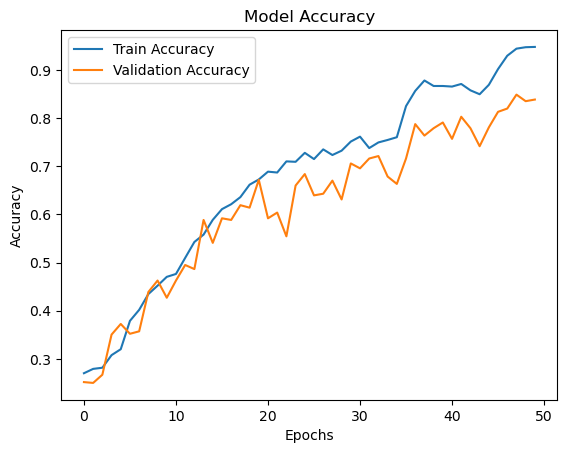

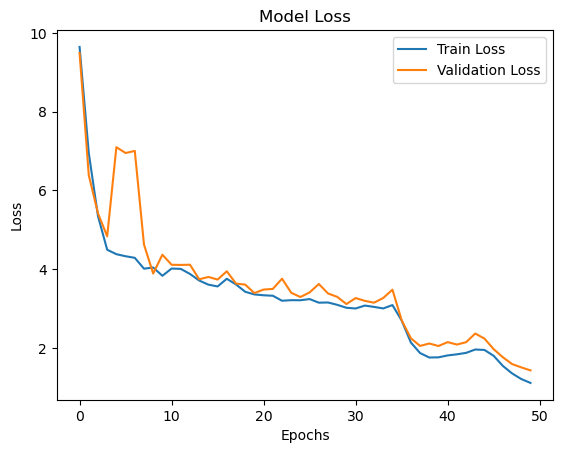

In [3]:


# ---------------- Enhanced DeepConvNet Architecture ----------------
def enhanced_deepconvnet(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # Block 1: Temporal Convolution
    x = Conv2D(16, kernel_size=(1, 64), padding='same', activation='relu', kernel_regularizer=l2(0.01))(input_layer)
    x = BatchNormalization()(x)
    x = DepthwiseConv2D(
        kernel_size=(input_shape[0], 1),
        depth_multiplier=2,
        activation='relu',
        depthwise_regularizer=l2(0.01),
    )(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Block 2: Spatial Convolution
    x = SeparableConv2D(
        32,
        kernel_size=(1, 16),
        padding='same',
        activation='relu',
        depthwise_regularizer=l2(0.01),
        pointwise_regularizer=l2(0.01),
    )(x)
    x = BatchNormalization()(x)
    x = AveragePooling2D(pool_size=(1, 4))(x)
    x = Dropout(0.4)(x)

    # Block 3: Residual Connections
    residual = Conv2D(64, kernel_size=(1, 1), padding='same', activation=None)(x)  # Match the number of filters

    x = Conv2D(64, kernel_size=(1, 8), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=(1, 8), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Add()([x, residual])  # Residual Connection
    x = Activation('relu')(x)

    # Block 4: Deeper Features
    x = Conv2D(128, kernel_size=(1, 4), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(1, 2))(x)
    x = Dropout(0.5)(x)

    # Fully Connected Layers
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.6)(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Build Model
    model = Model(inputs=input_layer, outputs=x)

    # Compile Model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# ---------------- Train and Evaluate the Model ----------------

input_shape = (features.shape[1], features.shape[2], 1)  # (n_channels, n_timepoints, 1)
num_classes = one_hot_labels.shape[1]
model = enhanced_deepconvnet(input_shape, num_classes)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.15,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predict test labels
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification Report and Confusion Matrix
print("\nClassification Report:\n", classification_report(y_test_classes, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_classes, y_pred))

# ---------------- Plot Training History ----------------

# Accuracy Plot
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Plot
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [4]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import clone_model

# Define number of splits for cross-validation
k_folds = 5

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Prepare labels for stratification
labels_for_stratify = np.argmax(one_hot_labels, axis=1)

# Store results
cv_accuracies = []
cv_losses = []

# Loop through each fold
fold = 1
for train_index, val_index in skf.split(augmented_features, labels_for_stratify):
    print(f"Training Fold {fold}/{k_folds}...")
    
    # Split data into training and validation sets
    X_train_cv, X_val_cv = augmented_features[train_index], augmented_features[val_index]
    y_train_cv, y_val_cv = one_hot_labels[train_index], one_hot_labels[val_index]
    
    # Clone the model to reset weights for each fold
    model_cv = clone_model(model)
    model_cv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model_cv.fit(
        X_train_cv, y_train_cv,
        validation_data=(X_val_cv, y_val_cv),
        epochs=50,
        batch_size=32,
        callbacks=[reduce_lr, early_stopping],
        verbose=1
    )
    
    # Evaluate the model on the validation set
    val_loss, val_accuracy = model_cv.evaluate(X_val_cv, y_val_cv, verbose=0)
    print(f"Fold {fold} - Validation Accuracy: {val_accuracy * 100:.2f}%, Validation Loss: {val_loss:.4f}")
    
    # Append results
    cv_accuracies.append(val_accuracy)
    cv_losses.append(val_loss)
    
    fold += 1

# Calculate and display cross-validation results
mean_accuracy = np.mean(cv_accuracies) * 100
std_accuracy = np.std(cv_accuracies) * 100
mean_loss = np.mean(cv_losses)

print(f"\nStratified Cross-Validation Results ({k_folds}-Fold):")
print(f"Mean Accuracy: {mean_accuracy:.2f}% ± {std_accuracy:.2f}%")
print(f"Mean Loss: {mean_loss:.4f}")


Training Fold 1/5...
Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 0.2777 - loss: 10.8847 - val_accuracy: 0.2495 - val_loss: 9.5567 - learning_rate: 0.0010
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.2783 - loss: 7.2250 - val_accuracy: 0.2495 - val_loss: 7.3987 - learning_rate: 0.0010
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.3087 - loss: 5.6398 - val_accuracy: 0.2777 - val_loss: 6.2164 - learning_rate: 0.0010
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 14s 123ms/step - accuracy: 0.3268 - loss: 4.7415 - val_accuracy: 0.3601 - val_loss: 6.4171 - learning_rate: 0.0010
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - accuracy: 0.3726 - loss: 4.7412 - val_accuracy: 0.3698 - val_loss: 6.3830 - learning_rate: 0.0010
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step - accuracy: 0.4115 - loss: 4.6868 - val_accuracy: 0.4403 - val_loss: 6.0432 - learning_rate: 0.0010
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 14s 121m